In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data processing
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.blocks import StdLinear, DenseBlock
from utils.clr import *
from collections import OrderedDict

In [3]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Model vars
bs = 1

True


## Data Injest

In [4]:
PATH = "../notebooks/data/dual_sen_sample_1.csv"

In [5]:
def moving_mean(time, data, lag=5):
    X = []
    y = []
    y_std = []
    for i in range(int(len(data)/lag)):
        X.append(time[(i*lag+lag)])
        y.append(np.mean(data[(i*lag):(i*lag+lag)]))
        y_std.append(np.std(data[(i*lag):(i*lag+lag)]))
        
    return X, y, y_std

In [6]:
df = pd.read_csv(PATH,parse_dates=['datetime','date'])

df.drop(['date','time','r_sen_1','s_sen_1','s_sen_2'],axis=1,inplace=True)
# df["mvg20_sen_2"] = df.loc[:,"r_sen_2"].rolling(window=20).mean()
# df["mvg20_sen_2"] = df["mvg20_sen_2"].round()
x, y, y_err = moving_mean(df['datetime'],df["r_sen_2"], 10)
df.loc[df['datetime'].isin(x),'avg20_sen_2'] = y
df.loc[df['datetime'].isin(x),'std20_sen_2'] = y_err
df.dropna(inplace=True)
df.head()

,datetime,r_sen_2,avg20_sen_2,std20_sen_2
10,2020-08-12 15:02:11,630,630.0,0.0
20,2020-08-12 15:12:11,630,630.0,0.0
30,2020-08-12 15:22:11,630,630.0,0.0
40,2020-08-12 15:32:11,630,630.0,0.0
50,2020-08-12 15:42:11,630,630.0,0.0


## Data visual

In [7]:
df_w = df.loc[df['std20_sen_2'] > 15]
df_t = pd.DataFrame(data={'datetime':pd.to_datetime("2020-08-07 13:40:31"),'r_sen_2':np.average(df_w['r_sen_2']), 'avg20_sen_2':np.average(df_w['avg20_sen_2']),'std20_sen_2':np.average(df_w['std20_sen_2'])},index=[0])
df_t = df_t.append(df_w)
df_t.sort_values(['datetime'],ascending=False,inplace=True)


for r_i, r_d in df.iterrows():
    for idx, row in df_t.iterrows():
        if r_d.datetime >= row.datetime:
            df.loc[r_i,'last_water'] = r_d.datetime - row.datetime
            break
        else:
            next

df['dow'] = df.datetime.dt.dayofweek
df.reset_index(inplace=True)
df.index = df.datetime
df.drop("datetime",axis=1,inplace=True)
df.dropna(inplace=True)
df_w

,datetime,r_sen_2,avg20_sen_2,std20_sen_2
5980,2020-08-16 18:28:31,428,517.4,113.558091
21530,2020-08-27 13:27:31,476,446.0,23.383755
35730,2020-09-06 10:01:53,420,516.4,114.248151
47390,2020-09-14 12:13:49,379,600.1,89.700000


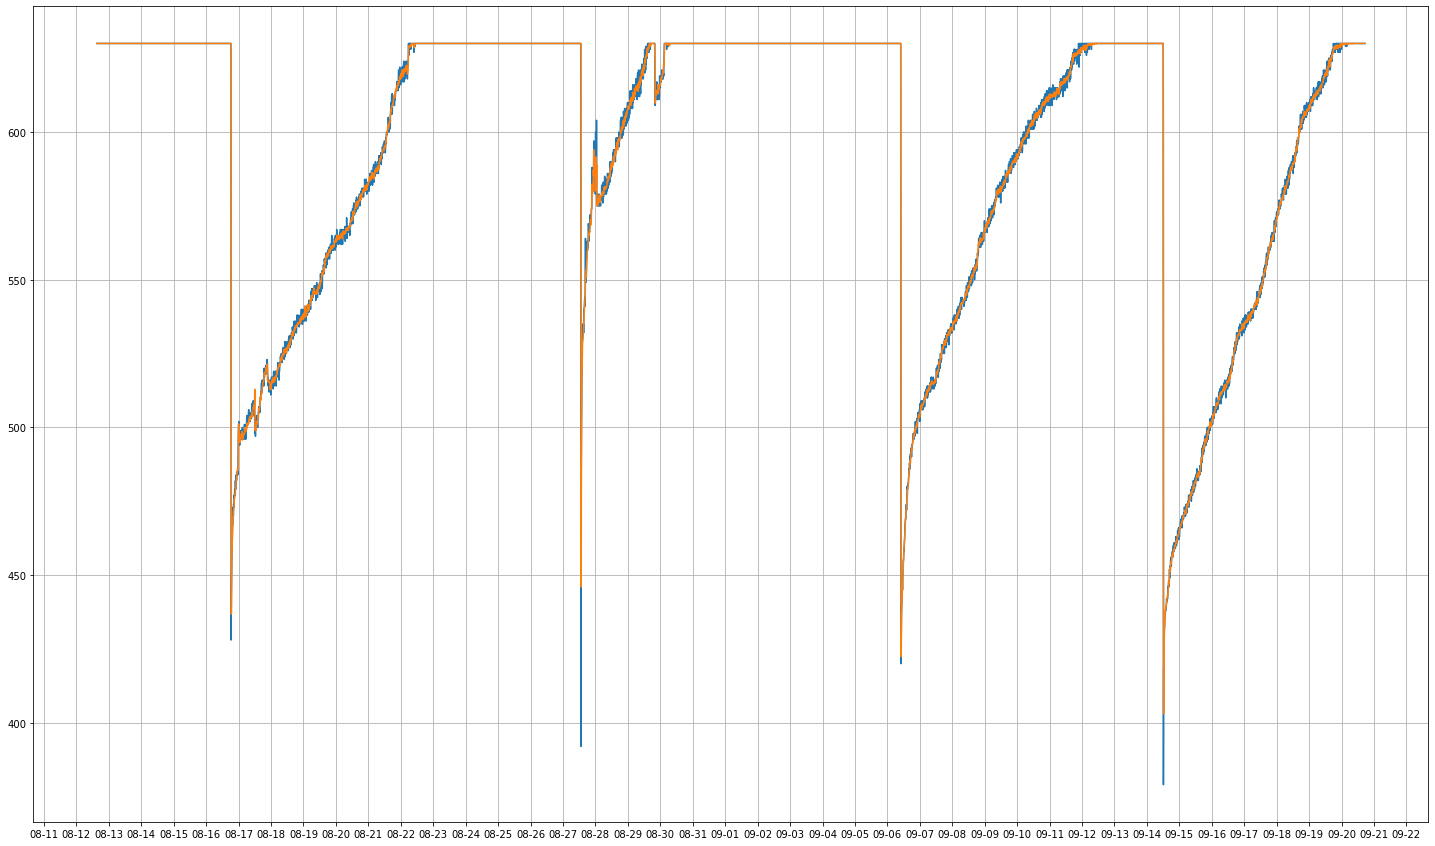

In [8]:
df_ts = df.copy()

fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts.loc[:,'r_sen_2'],label='data')
ax.plot(df_ts.loc[:,'avg20_sen_2'],label='avgd')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.show()

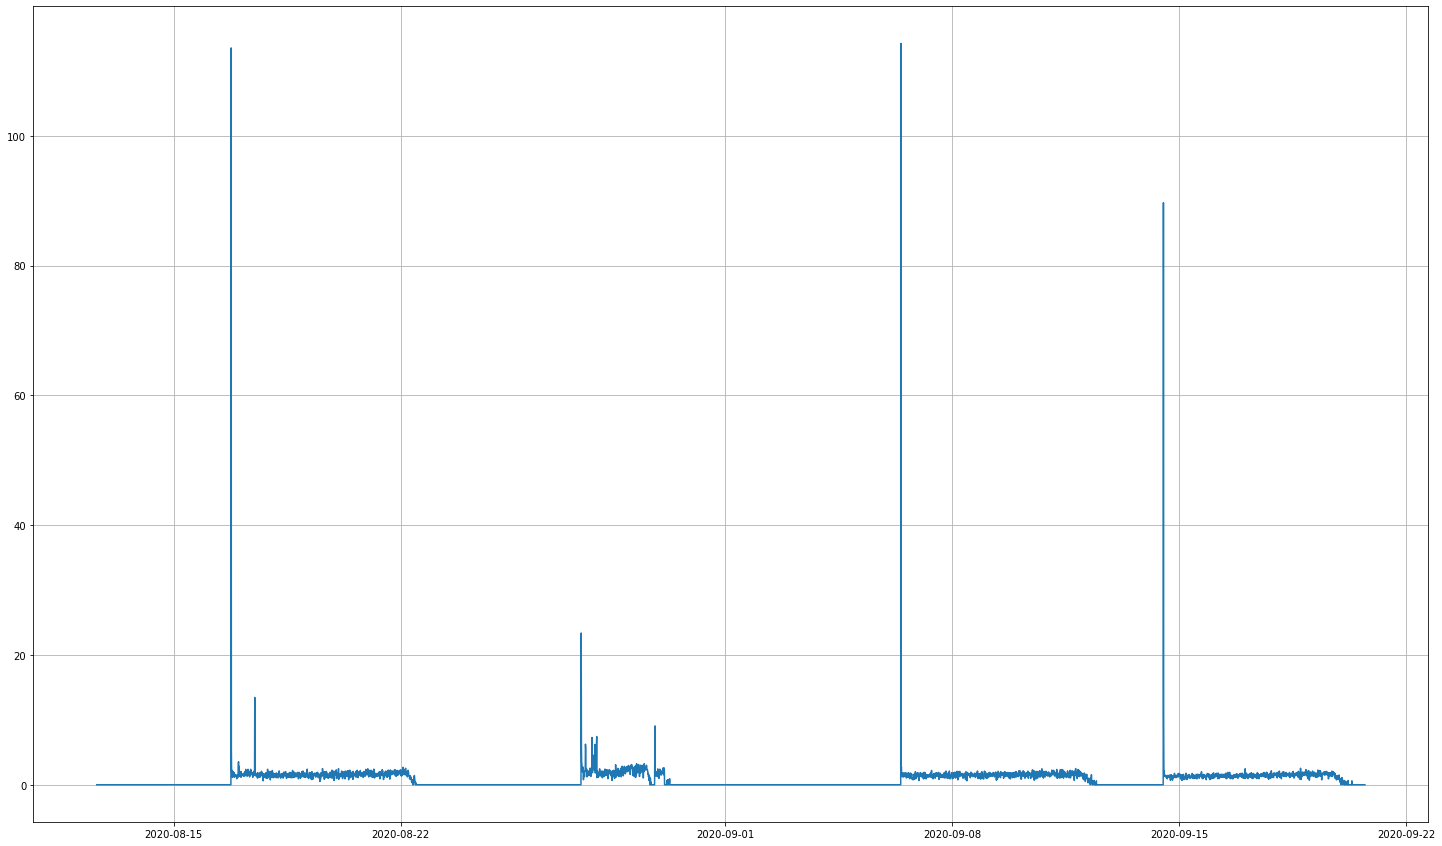

In [9]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts['std20_sen_2'])
plt.show()

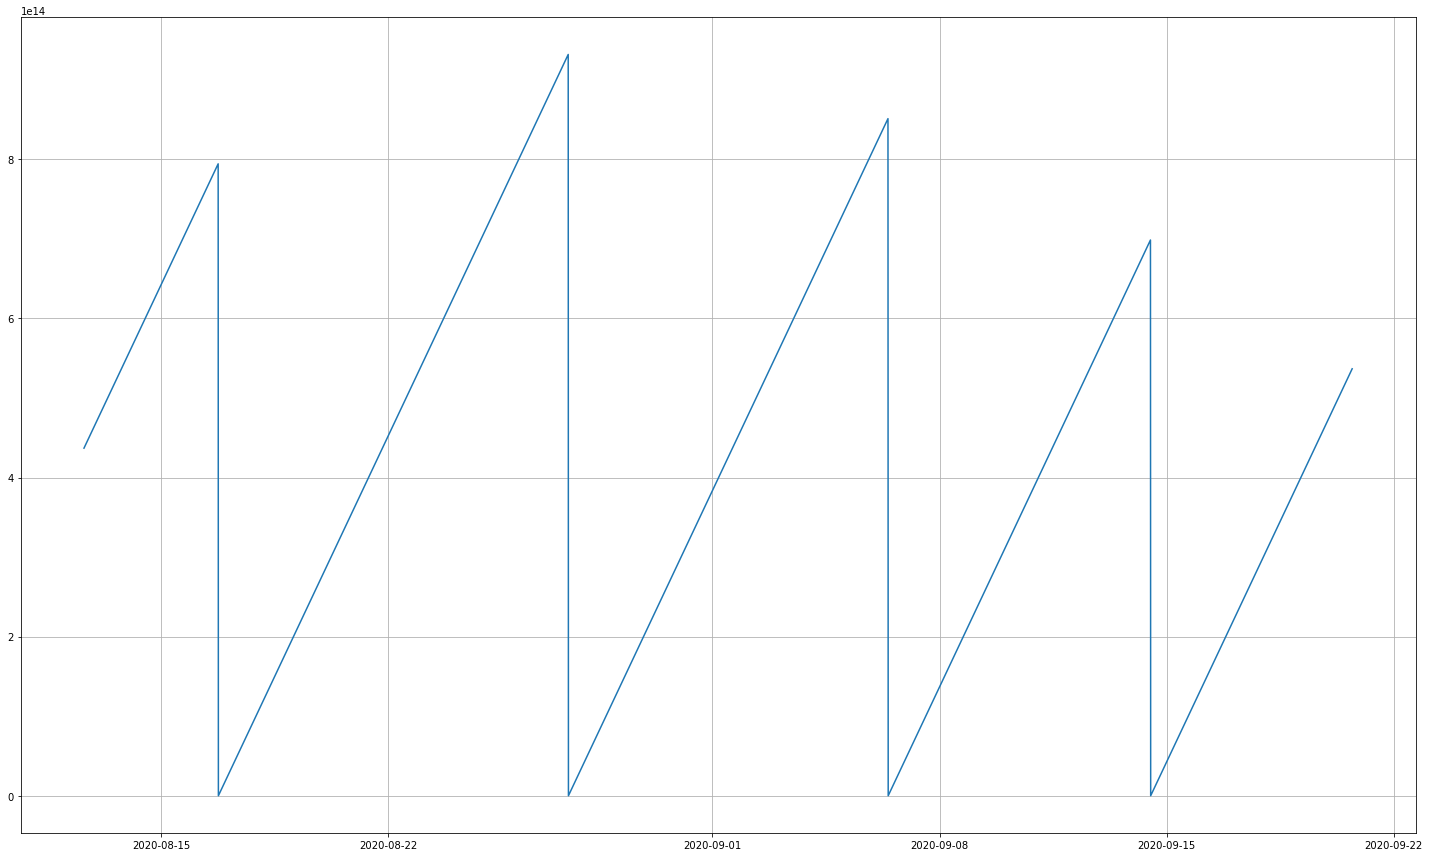

In [10]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts['last_water'])
plt.show()

In [11]:
df.head()

,index,r_sen_2,avg20_sen_2,std20_sen_2,last_water,dow
datetime,,,,,,
2020-08-12 15:02:11,10,630,630.0,0.0,5 days 01:21:40,2
2020-08-12 15:12:11,20,630,630.0,0.0,5 days 01:31:40,2
2020-08-12 15:22:11,30,630,630.0,0.0,5 days 01:41:40,2
2020-08-12 15:32:11,40,630,630.0,0.0,5 days 01:51:40,2
2020-08-12 15:42:11,50,630,630.0,0.0,5 days 02:01:40,2


## Data processing

In [12]:
def ds_make(df,y_col,win=20,md=False):    
    x, y = [], []
    for i in range(int(len(df)-win-1)):
        a = df.loc[i:(i+win)-1]
        x.append(a)
        if md:
            y.append(df.loc[i+win,['avg20_sen_2','std20_sen_2']])
        else:
            y.append([df.loc[i+win,'avg20_sen_2']])
    return np.array(x), np.array(y)

In [13]:
df_d = df.reset_index()
df_d.drop(['index','datetime'],axis=1,inplace=True)

df_d.loc[:,'last_water'] = df_d.loc[:,'last_water'].astype(int)/10000000000

#scale down for computing
scaler = MinMaxScaler(feature_range=(0,1))
for col in ['r_sen_2','avg20_sen_2','std20_sen_2','last_water','dow']:
    df_d.loc[:,col] = scaler.fit_transform(df_d[col].values.reshape(-1,1))

# split into DL data
win = 20
xs, ys = ds_make(df_d,"r_sen_2",win=win)
xs_t = []
for lookback in xs:
    xs_o = []
    for obs in lookback:
        for item in obs:
            xs_o.append(item)
    xs_t.append(xs_o)
    
df_d.head()

,r_sen_2,avg20_sen_2,std20_sen_2,last_water,dow
0,1.0,1.0,0.0,0.468908,0.333333
1,1.0,1.0,0.0,0.469552,0.333333
2,1.0,1.0,0.0,0.470196,0.333333
3,1.0,1.0,0.0,0.470840,0.333333
4,1.0,1.0,0.0,0.471483,0.333333


## Data loader

In [14]:
class Dataset(Dataset):
    def __init__(self, data, labels):
#         super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
trn_x, val_x, trn_y, val_y = train_test_split(xs,ys, test_size=0.2)

In [16]:
trn_ds = Dataset(trn_x, trn_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs)

## Model

In [17]:
class LinBench(nn.Module):
    def __init__(self, thicc, wide, out=1, dense=False):
        super().__init__()
        self.thicc = thicc          #num layers
        self.wide = wide            #num neuron
        self.out = out
        self.dense = dense
        
        self.layers = nn.ModuleList()
    
        for i in range(self.thicc-1):
            self.layers.append(StdLinear(self.wide,self.wide))
        self.layers.append(nn.Linear(self.wide,self.out))
        
    def forward(self, x):
        for i in range(self.thicc):
            x = self.layers[i](x)
        return x

In [23]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10.4}" * len(values)
    values = [epoch,*values] 
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, f'../data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')
names = ["ep / it","trn_loss","val_loss"]
layout = "{!s:10} " * len(names)

In [31]:
net = LinBench(3,win*5)

In [32]:
if use_cuda:
#     [net.cuda() for _,net in nets]
    net.cuda()
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 2e-4

optim = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.MSELoss()

scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(trn_ds)//2)
window = 200

In [33]:
def train(net,epochs):
    t_ls = []
    v_ls = []
    vals = {}
    print(layout.format(*names))
    for epoch in range(epochs):
        trn_it = iter(trn_dl)
        val_it = iter(val_dl)
        for i, (batch, ys) in enumerate(trn_it, 0):
            batch = np.reshape(batch, (-1))
            ys = np.reshape(ys, (-1))
            batch = batch.type(dtype)
            ys = ys.type(dtype)
            
            net.train()
            scheduler.batch_step()
            optim.zero_grad()
            pred = net(batch)
            ls = loss(pred, ys)
            
            ls.backward()
            optim.step()
            
            t_ls.append(ls.item())
            
            if i % window == 0:
                net.eval()
                with torch.no_grad():
                    v_bat, v_ys = next(val_it)
                    v_bat = np.reshape(v_bat,(-1))
                    v_ys = np.reshape(v_ys,(-1))
                    v_bat = v_bat.type(dtype)
                    v_ys = v_ys.type(dtype)
                    
                    v = net(v_bat)
                    v_loss = loss(v, v_ys)
                    v_ls.append(v_loss.item())

                vals[epoch]= [np.mean(t_ls[-window:]), v_ls[-1]]
                print_stats(f'{epoch+1} / {i+1}', vals[epoch], 4)
    return vals, t_ls, v_ls

In [34]:
vals, trn_loss, val_loss = train(net, 5)

ep / it    trn_loss   val_loss   
  1 / 1    1.10       1.04      
 1 / 201   0.06       6.56      
 1 / 401   0.00       0.00      
 1 / 601   0.00       1.01      
 1 / 801   0.01       0.00      
 1 / 1001  0.00       2.63      
 1 / 1201  0.00       2.39      
 1 / 1401  0.01       0.00      
 1 / 1601  0.00       0.10      
 1 / 1801  0.00       4.25      
 1 / 2001  0.00       0.00      
 1 / 2201  0.01       0.00      
 1 / 2401  0.00       0.00      
 1 / 2601  0.00       0.00      
 1 / 2801  0.00       0.00      
 1 / 3001  0.00       1.04      
 1 / 3201  0.00       0.00      
 1 / 3401  8.57       4.57      
 1 / 3601  0.00       0.00      
 1 / 3801  0.00       0.00      
 1 / 4001  0.00       6.41      
 1 / 4201  7.62       1.12      
 1 / 4401  0.00       0.00      
  2 / 1    0.00       1.10      
 2 / 201   8.59       1.77      
 2 / 401   0.00       0.00      
 2 / 601   0.00       1.43      
 2 / 801   0.00       1.86      
 2 / 1001  0.00       7.18      
 2 / 1201

In [35]:
trn_it = iter(trn_dl)
batch, ys = next(trn_it)
batch = np.reshape(batch,(-1))
batch = batch.type(dtype)
ys = ys.type(dtype)
pred = net(batch)
print(pred)
print(ys)

tensor([0.5896], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[0.5866]], device='cuda:0')


In [36]:
val_it = iter(val_dl)
v = []
v_ys = []
net.eval()
for batch in range(len(val_dl)//bs):
    with torch.no_grad():
        v_bat, v_y = next(val_it)
        v_bat = np.reshape(v_bat,(-1))
        v_y = np.reshape(v_y,(-1))
        v_bat = v_bat.type(dtype)

        v.append(net(v_bat).item())
        v_ys.append(v_y)

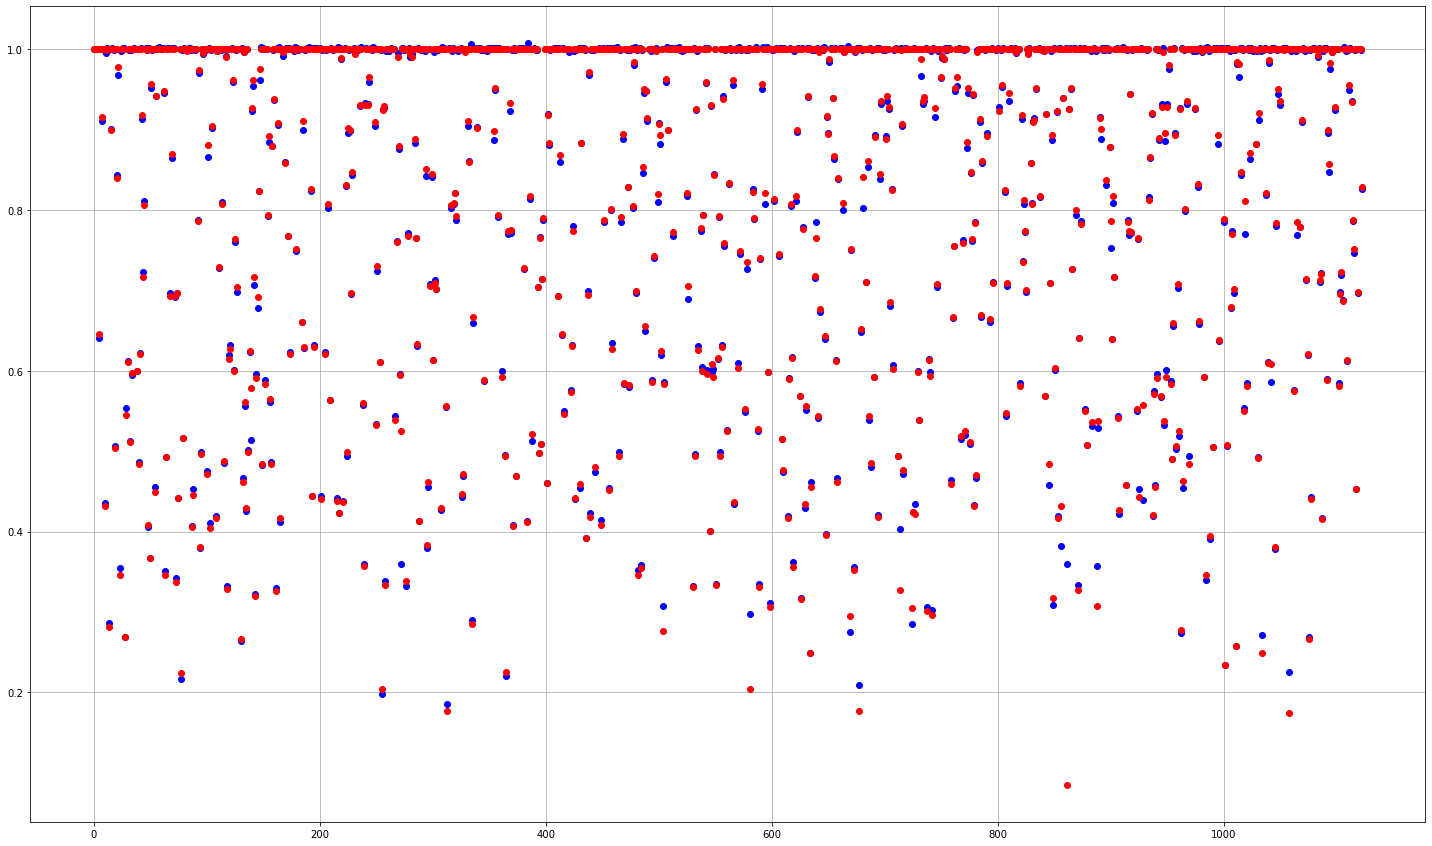

In [37]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(v,'bo',label='preds')
ax.plot(v_ys,'ro',label='truth')
plt.show()

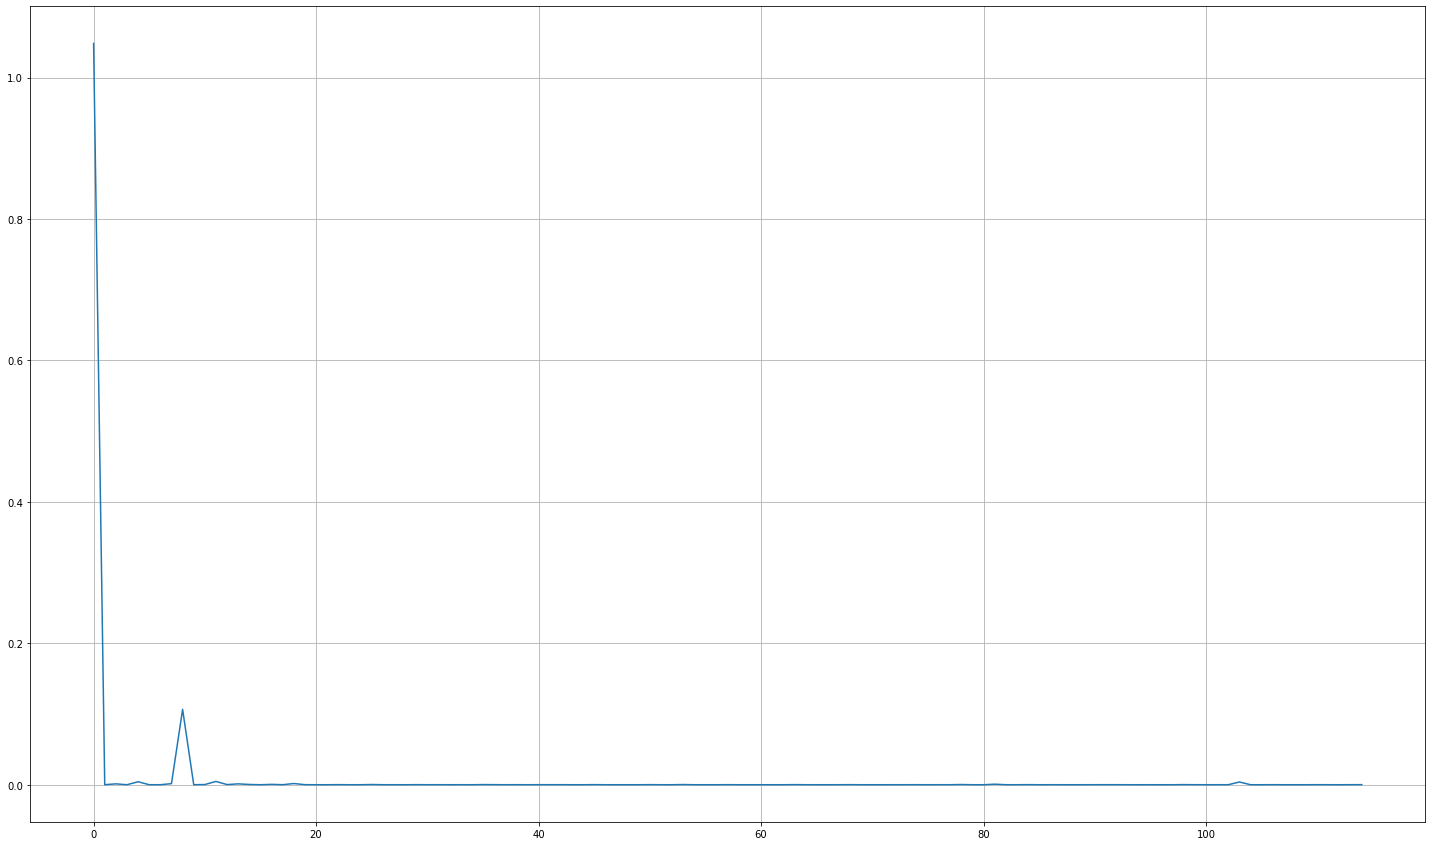

In [38]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(val_loss,label='preds')
plt.show()

Reference


https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205